In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import os 
import datetime as dt

import utils 

In [2]:
DATA_PATH = '../../data/stocks'

In [3]:
tickers = ['CPSEETF', 
           'MOM100', 
            'ICICIB22', 
           'MON100', 
           'GOLDBEES',
           'NIFTYBEES',
           'HDFCSML250']
tickers = [t + '.NS' for t in tickers]
tickers

['CPSEETF.NS',
 'MOM100.NS',
 'ICICIB22.NS',
 'MON100.NS',
 'GOLDBEES.NS',
 'NIFTYBEES.NS',
 'HDFCSML250.NS']

In [4]:
df = utils.download_and_cache(tickers, DATA_PATH)
nifty50 = utils.download_and_cache(['^NSEI'], DATA_PATH)

In [5]:
df_close = pd.concat([df[k]
 .query('Volume > 0')
 .Close.rename(k) for k in df.keys()], axis=1).dropna()

df_close

,CPSEETF.NS,MOM100.NS,ICICIB22.NS,MON100.NS,GOLDBEES.NS,NIFTYBEES.NS,HDFCSML250.NS
Date,,,,,,,
2023-02-21,39.029999,32.470001,58.529999,99.750000,48.259998,195.259995,93.480003
2023-02-22,38.619999,32.009998,57.970001,97.959999,48.160000,192.509995,92.019997
2023-02-23,38.639999,31.959999,58.110001,98.419998,47.860001,192.009995,90.589996
2023-02-24,39.049999,31.980000,58.060001,98.510002,47.779999,191.460007,90.589996
2023-02-27,39.430000,31.600000,58.070000,98.019997,47.439999,190.559998,89.970001
...,...,...,...,...,...,...,...
2024-08-19,102.830002,62.090000,116.680000,158.699997,60.340000,274.429993,177.070007
2024-08-20,102.699997,62.290001,117.410004,161.130005,60.669998,275.829987,178.440002
2024-08-21,102.739998,62.560001,117.769997,160.699997,60.380001,276.119995,179.759995


In [6]:
df_ret = df_close.pct_change().dropna()
df_ret.loc[df_ret.gt(1).any(axis=1)]

,CPSEETF.NS,MOM100.NS,ICICIB22.NS,MON100.NS,GOLDBEES.NS,NIFTYBEES.NS,HDFCSML250.NS
Date,,,,,,,


In [25]:
df_close.loc['2021-06-17':'2021-06-18', 'MON100.NS'] *= 10
df_close.loc['2019-12-19':'2019-12-20', ['GOLDBEES.NS']] *= 100
df_close.loc['2019-12-19':'2019-12-20', ['NIFTYBEES.NS']] *= 10
df_ret = df_close.pct_change().dropna()
df_ret.loc[df_ret.gt(1).any(axis=1)]

,CPSEETF.NS,MOM100.NS,ICICIB22.NS,MON100.NS,GOLDBEES.NS,NIFTYBEES.NS,HDFCSML250.NS
Date,,,,,,,


<Axes: >

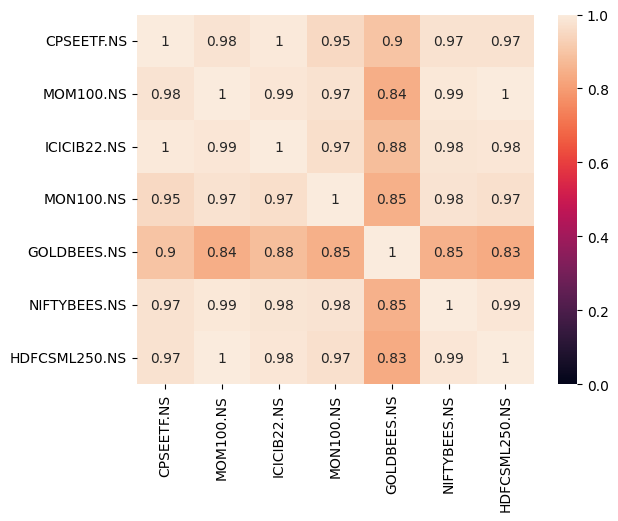

In [26]:
sns.heatmap(df_close.corr(), annot=True, vmax=1, vmin=0)

## Optimization

In [27]:
from skfolio import Population, RiskMeasure, BasePortfolio, MultiPeriodPortfolio
from skfolio.optimization import (
    EqualWeighted, 
    InverseVolatility, 
    ObjectiveFunction, 
    MeanRisk,
    HierarchicalRiskParity,
    NestedClustersOptimization,
    RiskBudgeting)

from sklearn.model_selection import train_test_split

In [28]:
df_nse = nifty50['^NSEI'].query('Volume > 0')['Close'].pct_change().dropna()
df_nse

Date
2013-01-22   -0.005557
2013-01-23    0.000959
2013-01-24   -0.005773
2013-01-25    0.009187
2013-01-28    0.000025
                ...   
2024-08-19    0.001284
2024-08-20    0.005136
2024-08-21    0.002889
2024-08-22    0.001667
2024-08-23    0.000470
Name: Close, Length: 2816, dtype: float64

In [29]:
df_train, df_test = train_test_split(df_ret, test_size=0.3, shuffle=False)
df_nse_test = df_nse.loc[df_test.index[0].strftime('%Y-%m-%d'):]

df_nse_test

Date
2024-03-12    0.000137
2024-03-13   -0.015133
2024-03-14    0.006771
2024-03-15   -0.005567
2024-03-18    0.001469
                ...   
2024-08-19    0.001284
2024-08-20    0.005136
2024-08-21    0.002889
2024-08-22    0.001667
2024-08-23    0.000470
Name: Close, Length: 106, dtype: float64

In [30]:
benchmark = BasePortfolio(returns=df_nse_test, observations=df_nse_test.index, name='NIFTY50')

In [31]:
model_equwt = EqualWeighted()
model_equwt.fit(df_train)

EqualWeighted()

In [32]:
model_minvar = InverseVolatility()
model_minvar.fit(df_train)

InverseVolatility()

In [33]:
model_mincvar = MeanRisk(
    risk_measure = RiskMeasure.CVAR,
    objective_function = ObjectiveFunction.MINIMIZE_RISK,
    portfolio_params = dict(name='Min CVaR')
)
model_mincvar.fit(df_train)

MeanRisk(portfolio_params={'name': 'Min CVaR'}, risk_measure=CVaR)

In [34]:
model_hier_cluster = HierarchicalRiskParity(
    risk_measure = RiskMeasure.CVAR,
    portfolio_params = dict(name = 'Hierarchical Clustering')
)
model_hier_cluster.fit(df_train)

HierarchicalRiskParity(portfolio_params={'name': 'Hierarchical Clustering'},
                       risk_measure=CVaR)

In [35]:
models = [model_equwt, model_minvar, model_mincvar, model_hier_cluster]
pop = Population([m.predict(df_test) for m in models] + [benchmark])
pop.set_portfolio_params(compounded=True)
pop.plot_cumulative_returns()

In [36]:
pop.plot_composition()

In [37]:
pop.summary()

,EqualWeighted,InverseVolatility,Min CVaR,Hierarchical Clustering,NIFTY50
Mean,0.14%,0.13%,0.090%,0.13%,0.11%
Annualized Mean,35.32%,33.58%,22.72%,32.71%,26.46%
Variance,0.0092%,0.0078%,0.0052%,0.0079%,0.010%
Annualized Variance,2.33%,1.96%,1.31%,2.00%,2.63%
Semi-Variance,0.0058%,0.0048%,0.0029%,0.0049%,0.0062%
Annualized Semi-Variance,1.46%,1.21%,0.74%,1.23%,1.57%
Standard Deviation,0.96%,0.88%,0.72%,0.89%,1.02%
Annualized Standard Deviation,15.26%,13.99%,11.43%,14.14%,16.23%
Semi-Deviation,0.76%,0.69%,0.54%,0.70%,0.79%
Annualized Semi-Deviation,12.10%,11.02%,8.59%,11.10%,12.54%


In [69]:
pop.composition() * 1_00_000

,EqualWeighted_EqualWeighted,EqualWeighted_EqualWeighted_1,EqualWeighted_EqualWeighted_2,EqualWeighted_EqualWeighted_3,EqualWeighted_EqualWeighted_4,EqualWeighted_EqualWeighted_5,EqualWeighted_EqualWeighted_6,EqualWeighted_EqualWeighted_7,EqualWeighted_EqualWeighted_8,EqualWeighted_EqualWeighted_9,...,HierarchicalRiskParity_Hierarchical Clustering_28,HierarchicalRiskParity_Hierarchical Clustering_29,HierarchicalRiskParity_Hierarchical Clustering_30,HierarchicalRiskParity_Hierarchical Clustering_31,HierarchicalRiskParity_Hierarchical Clustering_32,HierarchicalRiskParity_Hierarchical Clustering_33,HierarchicalRiskParity_Hierarchical Clustering_34,HierarchicalRiskParity_Hierarchical Clustering_35,HierarchicalRiskParity_Hierarchical Clustering_36,HierarchicalRiskParity_Hierarchical Clustering_37
asset,,,,,,,,,,,,,,,,,,,,,
CPSEETF.NS,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,...,14103.167528,14205.373014,14270.191565,5957.855644,6002.528770,6030.153937,6057.884865,6179.628150,6302.574427,6512.636566
MOM100.NS,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,...,10670.933588,10683.515456,10778.183453,9203.876819,9244.615553,9258.435394,9272.924614,9552.612986,9713.751901,9967.385336
ICICIB22.NS,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,...,8988.385812,9041.551103,9107.430846,8546.806887,8583.001716,8623.434992,8660.230360,8978.611588,9035.957189,9478.508503
MON100.NS,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,...,18654.017733,18931.454979,18946.853713,20645.478541,20775.002481,20693.971289,20346.445840,19779.868208,18693.890464,16753.695353
GOLDBEES.NS,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,...,22688.421934,22173.850323,21764.546372,23107.587389,22789.191370,22749.593626,22984.114993,21689.697210,22019.881997,22023.770276
NIFTYBEES.NS,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,...,15514.196063,15576.563862,15666.789883,16999.478354,17015.232852,17044.556092,17067.659083,17745.610303,17902.022528,18164.902282
HDFCSML250.NS,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,14285.714286,...,9380.877342,9387.691263,9466.004168,15538.916367,15590.427258,15599.854670,15610.740246,16073.971555,16331.921494,17099.101683


Inverse Volatility performance is sus, hence I'll perform walk forward validation

# Walk Forward Validation
- Train on the existing data and test for 30 days of data

In [38]:
from skfolio.model_selection import WalkForward, cross_val_predict

In [43]:
models

[EqualWeighted(),
 InverseVolatility(),
 MeanRisk(portfolio_params={'name': 'Min CVaR'}, risk_measure=CVaR),
 HierarchicalRiskParity(portfolio_params={'name': 'Hierarchical Clustering'},
                        risk_measure=CVaR)]

In [64]:
type(models[0]).__name__

'EqualWeighted'

In [65]:
cv = WalkForward(train_size=100, test_size=7, expend_train=True)

mp = cross_val_predict(model_hier_cluster, df_ret, cv=cv, portfolio_params=dict(name='WalkForward'))
pop = Population([
    cross_val_predict(m, df_ret, cv=cv, portfolio_params=dict(name=type(m).__name__))
    for m in models
])

In [66]:
pop.plot_cumulative_returns()

In [41]:
tmp = df_nse.loc[mp.returns_df.index[0].strftime('%Y-%m-%d'):]
pop = Population([
    mp, 
    BasePortfolio(returns=tmp, observations=tmp.index, name='NIFTY50')
    ])
pop.set_portfolio_params(compounded=True)
pop.plot_cumulative_returns(log_scale=True)

In [42]:
pop.summary()

,WalkForward,NIFTY50
Mean,0.14%,0.087%
Annualized Mean,35.04%,21.84%
Variance,0.0049%,0.0069%
Annualized Variance,1.24%,1.74%
Semi-Variance,0.0029%,0.0039%
Annualized Semi-Variance,0.74%,0.99%
Standard Deviation,0.70%,0.83%
Annualized Standard Deviation,11.15%,13.19%
Semi-Deviation,0.54%,0.63%
Annualized Semi-Deviation,8.59%,9.97%
